In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.stats import ttest_ind, ks_2samp


In [9]:
#exp_paradigm = '/mnt/labserver/HURTAK_Femke/Experimental_data/Optogenetics/Optobot/web/CsChrimson/231129_red_light'
#exp_paradigm = '/mnt/labserver/HURTAK_Femke/Experimental_data/Optogenetics/Optobot/web/GtACR2/231208_blue_light'
#exp_paradigm = '/mnt/labserver/HURTAK_Femke/Experimental_data/Optogenetics/Optobot/web/GtACR2/231208_blue_light_afternoon'
#exp_paradigm = '/mnt/labserver/HURTAK_Femke/Experimental_data/Optogenetics/Optobot/web/GtACR2/231219_blue_light_and_light_on'
#exp_paradigm = '/mnt/labserver/HURTAK_Femke/Experimental_data/Optogenetics/Optobot/CantonS/GtACR2/231219_light_off'
#exp_paradigm = '/mnt/labserver/HURTAK_Femke/Experimental_data/Optogenetics/Optobot/CantonS/GtACR2/231219_light_on'
#exp_paradigm = '/mnt/labserver/HURTAK_Femke/Experimental_data/Optogenetics/Optobot/G7/GtACR2/231129_blue_light'
exp_paradigm = '/mnt/labserver/HURTAK_Femke/Experimental_data/Optogenetics/Optobot/MDN/CsChrimson/231208'

In [10]:
def check_and_add_stimulation(data, initial_delay=10, on_duration=5, off_duration=15, repetitions=6, fps=80):
    # check if the data frame has a column 'stimulation'
    if 'stimulation' not in data.columns:
        data['stimulation'] = 0
    # if the stimulation is only zeros, add the stimulation
    if np.all(data['stimulation'] == 0):
        # create a list with the stimulation: '1' for on, '0' for off
        stimulation = [0]*initial_delay*fps + [1]*on_duration*fps + [0]*off_duration*fps
        stimulation = stimulation*repetitions
        stimulation = np.array(stimulation)
        data['stimulation'] = stimulation

    return data

def add_dlc_data(data, data_path, stim_data):
    # add a column 'stimulation' to the data frame, where the value is 1 if the
    # stimulus was on and 0 if the stimulus was off.
    dlc_data_path = os.path.join(data_path, 'resultsDLC')
    data['stimulation'] = 0
    # Add dlc data to the data frame
    start_frame = stim_data['fly0'][stim_data['stimulation_paradigm'][0]]['startFrame']
    end_frame = stim_data['fly0'][stim_data['stimulation_paradigm'][0]]['stopFrame']
    if 'on' in stim_data['stimulation_paradigm'][0]:
        data.loc[start_frame:end_frame, 'stimulation'] = 1
        # add DLC data
    # find file starting with 'vid_p6-0_' + stim and ending with '.h5'
    dlc_file = [f for f in os.listdir(dlc_data_path) if f.startswith('vid_p6-0_' + stim_data['stimulation_paradigm'][0]) and f.endswith('.h5')]
    dlc_data = pd.read_hdf(os.path.join(dlc_data_path, dlc_file[0]))
    # remove the first level of columns indexing
    dlc_data.columns = dlc_data.columns.droplevel(0)
    # set index from start_frame to end_frame
    dlc_data = dlc_data.set_index(np.arange(start_frame, end_frame))
    # add the dlc data to the data frame
    data = data.join(dlc_data)
    del dlc_file, dlc_data


    if len(stim_data['stimulation_paradigm']) == 1:
        return data
    
    for stim in stim_data['stimulation_paradigm'][1:]: # list on 'off0', 'on0', 'off1', 'on1', ...
        start_frame = stim_data['fly0'][stim]['startFrame']
        end_frame = stim_data['fly0'][stim]['stopFrame']
        if 'on' in stim:
            data.loc[start_frame:end_frame, 'stimulation'] = 1
            # add DLC data
        # find file starting with 'vid_p6-0_' + stim and ending with '.h5'
        dlc_file = [f for f in os.listdir(dlc_data_path) if f.startswith('vid_p6-0_' + stim) and f.endswith('.h5')]
        dlc_data = pd.read_hdf(os.path.join(dlc_data_path, dlc_file[0]))
        # remove the first level of columns indexing
        dlc_data.columns = dlc_data.columns.droplevel(0)
        # set index from start_frame to end_frame
        dlc_data = dlc_data.set_index(np.arange(start_frame, end_frame))
        # rename the index to 'frame'
        dlc_data.index.names = ['frame']
        # add the dlc data to the data frame
        data.iloc[start_frame:end_frame, :].loc[:,dlc_data.columns] = dlc_data
        del dlc_file, dlc_data

    return data

def tracking_motion_energy(data):
    # calculate the motion energy of the legs
    # data is a pandas dataframe with the columns containing the x and y
    # coordinates of the legs
    # returns a pandas dataframe with the motion energy of each leg
    # the motion energy is calculated as the sum of the squared differences
    # between the coordinates of the leg in the current frame and the
    # coordinates of the leg in the previous frame
    for point in data.columns.levels[0][1:-1]:
        dx = data.loc[:, (point, 'x')].diff()
        dx = dx.fillna(0)
        dy = data.loc[:, (point, 'y')].diff()
        dy = dy.fillna(0)
        me = dx.values**2 + dy.values**2
        # create a new column
        data.loc[:,(point,'me')] = me
    # sort the columns by the first level
    data = data.sort_index(axis=1)
    return data

def tracking_velocity(data):
    '''
    Adds a column to data with the velocity of the fly, computed as the
    distance between the centroid of the fly in the current frame and the
    centroid of the fly in the previous frame.
    '''
    # calculate the velocity of the fly
    dx = data.loc[:, (0, 'pos_x')].diff()
    dx = dx.fillna(0)
    dy = data.loc[:, (0, 'pos_y')].diff()
    dy = dy.fillna(0)
    velocity = np.sqrt(dx.values**2 + dy.values**2)
    # add the velocity to the data frame
    data.loc[:, (0, 'velocity')] = velocity
    # sort the columns by the first level
    data = data.sort_index(axis=1)
    return data


def add_legs_motion_energy(data):
    '''
    Adds a column to data with the motion energy of the legs.
    We sum the ME of the end effectors of all legs.
    '''
    list_legs = ['LFclaw', 'LMclaw', 'LHclaw', 'RFclaw', 'RMclaw', 'RHclaw']
    # check if the columns are in the data frame
    for leg in list_legs:
        if leg not in data.columns.levels[0]:
            print('The leg {} is not in the data frame'.format(leg))
            return data
    # calculate the motion energy of the legs
    leg_me_subset = data.loc[:, (list_legs, 'me')]
    leg_me = leg_me_subset.sum(axis=1)
    # add the motion energy to the data frame
    data.loc[:, ('legs', 'me')] = leg_me
    # sort the columns by the first level
    data = data.sort_index(axis=1)
    return data

def add_savgol_filtered_x_y(data):
    '''
    Adds columns to the data frame with the x and y coordinates filtered with
    a Savitzky-Golay filter. Rename the initial x and y columns to x_raw and
    y_raw.
    '''
    for point in data.columns.levels[0][1:-1]:
        data.loc[:,(point,'x_raw')] = data.loc[:,(point,'x')]
        data.loc[:,(point,'y_raw')] = data.loc[:,(point,'y')]
        data.loc[:,(point,'x')] = savgol_filter(data.loc[:,(point,'x')], 51, 3)
        data.loc[:,(point,'y')] = savgol_filter(data.loc[:,(point,'y')], 51, 3)
    # sort the columns by the first level
    data = data.sort_index(axis=1)
    return data

def load_data(data_path):
    centroid_file_name_list = [f for f in os.listdir(data_path) if f.endswith('.pkl')]
    if len(centroid_file_name_list) != 1:
        print('There are {} files ending with .pkl in {}'.format(len(centroid_file_name_list), data_path))
        return pd.DataFrame()
    centroid_file_name = centroid_file_name_list[0]
    centroid_file_path = os.path.join(data_path, centroid_file_name)
    stimulation_file_name = 'experiment_dict.npy'
    stimulation_file_path = os.path.join(data_path, stimulation_file_name)
    stim_data = np.load(stimulation_file_path, allow_pickle=True).item()
    data = pd.read_pickle(centroid_file_path)

    try:
        data = add_dlc_data(data, data_path, stim_data)
    except:
        print('Could not add DLC data')
        return pd.DataFrame()

    data = check_and_add_stimulation(data, initial_delay=25, on_duration=5, off_duration=0, repetitions=6, fps=80)
    #data = check_and_add_stimulation(data)

    data = add_savgol_filtered_x_y(data)
    
    data = tracking_motion_energy(data)
    
    data = tracking_velocity(data)

    data = add_legs_motion_energy(data)

    return data

In [11]:
def stat_test_sign(p):
    if p <0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

def get_on_off_entry(data, level1 = 'legs', level2 = 'me',duration=5,fps=80):
    '''
    Returns a dataframe with the average and std of motion energy of the legs
    when the stimulus is on and off, separating everytime the stimulus is on
    and off.

    Returns:
    -------
    on_off_me: dataframe
        dataframe with 3 columns: 'stimulation', 'me', 'std'
        each row is a different stimulation period
    '''
    # get the stimulation periods
    stim = data['stimulation']
    stim_diff = np.diff(stim)
    stim_on = np.where(stim_diff == 1)[0]
    # create a dataframe with the average and std of the measured features
    # when the stimulus is on and off
    on_off_me = pd.DataFrame(columns=['stimulation', level2, 'std', 'nb_pts'])
    for i in range(len(stim_on)):
        me_on = data.loc[stim_on[i]:stim_on[i]+duration*fps, (level1, level2)]
        on_off_me.loc[i, 'stimulation'] = 1
        on_off_me.loc[i, level2] = me_on.mean()
        on_off_me.loc[i, 'std'] = me_on.std()
        on_off_me.loc[i, 'nb_pts'] = len(me_on)
    index = len(stim_on)
    for i in range(len(stim_on)):
        me_off = data.loc[stim_on[i]-duration*fps:stim_on[i], (level1, level2)]
        on_off_me.loc[i+index, 'stimulation'] = 0
        on_off_me.loc[i+index, level2] = me_off.mean()
        on_off_me.loc[i+index, 'std'] = me_off.std()
        on_off_me.loc[i+index, 'nb_pts'] = len(me_off)
    return on_off_me
    


In [12]:
# find all the folders in the experiment paradigm folder
folders = [f for f in os.listdir(exp_paradigm) if os.path.isdir(os.path.join(exp_paradigm, f))]

In [13]:
on_off_me = pd.DataFrame(columns=['stimulation', 'me', 'std', 'nb_pts'])
for folder in folders:
    data = load_data(os.path.join(exp_paradigm, folder))
    if data.empty:
        continue
    on_off_me_exp = get_on_off_entry(data, level1 = 'legs', level2 = 'me')

    # join the two dataframes
    on_off_me = pd.concat([on_off_me, on_off_me_exp], ignore_index=True)
    

There are 0 files ending with .pkl in /mnt/labserver/HURTAK_Femke/Experimental_data/Optogenetics/Optobot/MDN/CsChrimson/231208/151132_s2a9_p6-0


/tmp/ipykernel_15117/1086886887.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, ('legs', 'me')] = leg_me
/tmp/ipykernel_15117/1086886887.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, ('legs', 'me')] = leg_me
/tmp/ipykernel_15117/1086886887.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, u

Could not add DLC data


/tmp/ipykernel_15117/1086886887.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, ('legs', 'me')] = leg_me


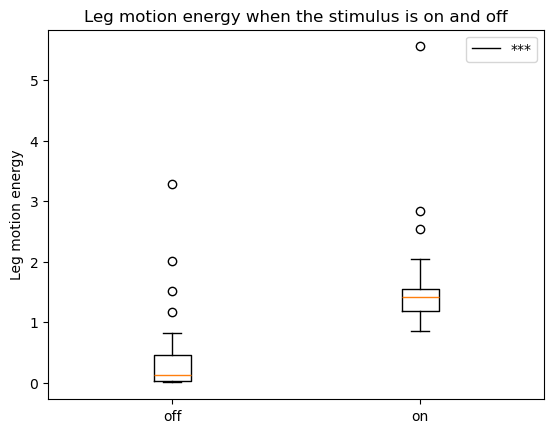

In [14]:
# make a boxplot of the motion energy when the stimulus is on and off
plt.figure()
plt.boxplot([on_off_me[on_off_me['stimulation']==0]['me'], on_off_me[on_off_me['stimulation']==1]['me']])
plt.xticks([1,2], ['off', 'on'])
#plt.ylim([0, 500])
plt.ylabel('Leg motion energy')
plt.title('Leg motion energy when the stimulus is on and off')
# add a legend with the p value
A = on_off_me[on_off_me['stimulation']==0]['me'].values
B = on_off_me[on_off_me['stimulation']==1]['me'].values
p_value = ks_2samp(
    A,
    B,
    )[1]
plt.legend([stat_test_sign(p_value)], loc='upper right')
#plt.savefig(os.path.join(exp_paradigm, 'motion_energy_on_off.png'))


In [15]:
on_off_me = pd.DataFrame(columns=['stimulation', 'velocity', 'std', 'nb_pts'])
for folder in folders:
    data = load_data(os.path.join(exp_paradigm, folder))
    if data.empty:
        continue
    #on_off_me_exp = get_on_of_entry(data, level1 = 'legs', level2 = 'me')
    on_off_vel_exp = get_on_off_entry(data,level1=0,level2='velocity')

    # join the two dataframes
    on_off_me = pd.concat([on_off_me, on_off_vel_exp], ignore_index=True)

There are 0 files ending with .pkl in /mnt/labserver/HURTAK_Femke/Experimental_data/Optogenetics/Optobot/MDN/CsChrimson/231208/151132_s2a9_p6-0


/tmp/ipykernel_15117/1086886887.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, ('legs', 'me')] = leg_me
/tmp/ipykernel_15117/1086886887.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, ('legs', 'me')] = leg_me
/tmp/ipykernel_15117/1086886887.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, u

Could not add DLC data


/tmp/ipykernel_15117/1086886887.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.loc[:, ('legs', 'me')] = leg_me


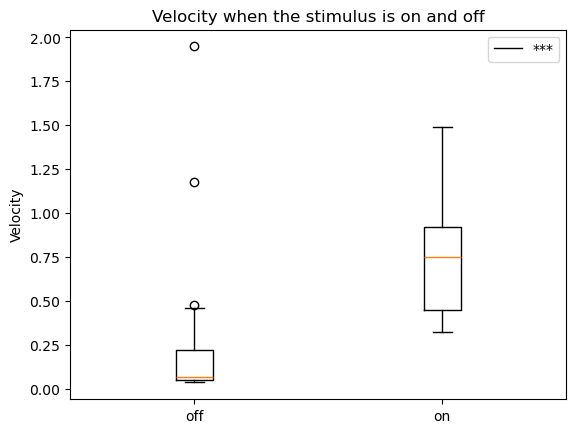

In [16]:


# make a boxplot of the motion energy when the stimulus is on and off
plt.figure()
plt.boxplot([on_off_me[on_off_me['stimulation']==0]['velocity'], on_off_me[on_off_me['stimulation']==1]['velocity']])
plt.xticks([1,2], ['off', 'on'])
#plt.ylim([0, 500])
plt.ylabel('Velocity')
plt.title('Velocity when the stimulus is on and off')
# add a legend with the p value
A = on_off_me[on_off_me['stimulation']==0]['velocity'].values
B = on_off_me[on_off_me['stimulation']==1]['velocity'].values
p_value = ks_2samp(
    A,
    B,
    )[1]
plt.legend([stat_test_sign(p_value)], loc='upper right')
#plt.savefig(os.path.join(exp_paradigm, 'motion_energy_on_off.png'))

